In [1]:
import math

Q96 = 2**96
MAX_DELTA = 0.01


def lt_delta(x, y, d):
    return abs(x - y) < d


# Tick to sqrt price x 96
def tick_to_sqrt_p_96(tick):
    return int(1.0001 ** (tick / 2) * Q96)


def tick_to_sqrt_p(tick):
    return 1.0001 ** (tick / 2)


def tick_to_p(tick):
    return 1.0001**tick


def sqrt_p_to_tick(sqrt_price):
    return int(round(2 * math.log(sqrt_price) / math.log(1.0001)))


def round_tick(tick, tick_spacing):
    return int(round(tick / tick_spacing) * tick_spacing)


def calc_x(L, s):
    assert s >= 0, f"{s}"
    if s == 0:
        return math.inf
    return L / s


def calc_y(L, s):
    assert s >= 0, f"{s}"
    return L * s


def calc_dx(L, s_lo, s_hi):
    assert s_lo >= 0, f"{s_lo}"
    assert s_hi >= 0, f"{s_hi}"
    if s_lo >= s_hi:
        return 0
    if s_lo == 0:
        return math.inf
    # 1 / math.inf = 0
    return L * (1 / s_lo - 1 / s_hi)


def calc_dy(L, s_lo, s_hi):
    assert s_lo >= 0, f"{s_lo}"
    assert s_hi >= 0, f"{s_hi}"
    if s_lo >= s_hi:
        return 0
    return L * (s_hi - s_lo)


# dx = L(1/s_lo - 1/s_hi)
# dy = L(s_hi - s_lo)
def calc_dx_to_s_lo(L, s_hi, dx):
    assert s_hi > 0, f"{s_hi}"
    assert dx >= 0, f"{dx}"
    return 1 / (dx / L + 1 / s_hi)


def calc_dx_to_s_hi(L, s_lo, dx):
    assert s_lo > 0, f"{s_lo}"
    assert dx >= 0, f"{dx}"
    return 1 / (-dx / L + 1 / s_lo)


def calc_dy_to_s_lo(L, s_hi, dy):
    assert s_hi > 0, f"{s_hi}"
    assert dy >= 0, f"{dy}"
    return -dy / L + s_hi


def calc_dy_to_s_hi(L, s_lo, dy):
    assert s_lo > 0, f"{s_lo}"
    assert dy >= 0, f"{dy}"
    return dy / L + s_lo


# next
def nxt(pool, i, up):
    if i + 1 >= len(pool):
        if up:
            return (math.inf, math.inf, 0)
        else:
            return (0, 0, 0)
    return pool[i + 1]


def calc_amt_out(i, o, di, f):
    di *= 1 - f
    return o * di / (i + di)


# Optimal dy amount in (including fees) into pool A (dya -> dx -> dyb)
def calc_opt_dy_in(xa, ya, xb, yb, fa, fb):
    k0 = xa * ya * xb * yb * (1 - fa) * (1 - fb)
    k1 = (xb + xa * (1 - fb)) * (1 - fa)
    a = k1 * k1
    b = 2 * k1 * xb * ya
    c = (xb * ya) ** 2 - k0
    return (-b + math.sqrt(b * b - 4 * a * c)) / (2 * a)


def calc_opt_dya(la, sa, lb, sb, fa, fb):
    assert 0 <= sa < sb, f"sa: {sa}, sb: {sb}"
    xa = calc_x(la, sa)
    ya = calc_y(la, sa)
    xb = calc_x(lb, sb)
    yb = calc_y(lb, sb)
    # print(f"xa: {xa}, ya: {ya}, xb: {xb}, yb: {yb}")

    dya = calc_opt_dy_in(xa, ya, xb, yb, fa, fb)
    if dya <= 0:
        return (0, 0, sa)

    dx = calc_amt_out(ya, xa, dya, fa)
    dyb = calc_amt_out(xb, yb, dx, fb)
    assert dya <= dyb, f"{dya} > {dyb}"
    # Check sa and sb after swaps
    sa_swap = calc_dy_to_s_hi(la, sa, dya * (1 - fa))
    sb_swap = calc_dx_to_s_lo(lb, sb, dx * (1 - fb))
    assert (
        sa <= sa_swap <= sb_swap <= sb
    ), f"sa_swap: {sa_swap}, sb_swap: {sb_swap}, sa: {sa}, sb: {sb}"
    assert lt_delta(sa_swap, sb_swap, MAX_DELTA), f"{abs(sa_swap - sb_swap)}"
    return (dya, dyb, sa_swap)


def swap_to_sa_hi(xa, xb, la, sa, sa_lo, sa_hi, lb, sb, sb_lo, sb_hi, fa, fb):
    dya = calc_dy(la, sa_lo, sa_hi) / (1 - fa)
    sa = sa_hi
    sb = calc_dx_to_s_lo(lb, sb_hi, xa * (1 - fb))
    assert sb_lo <= sb, f"{sb_lo} > {sb}"
    dyb = calc_dy(lb, sb, sb_hi)
    return (dya, dyb, sa, sb)


def swap_to_sb_lo(xa, xb, la, sa, sa_lo, sa_hi, lb, sb, sb_lo, sb_hi, fa, fb):
    dx = min(xa, xb / (1 - fb))
    if dx == xa:
        sa = sa_hi
    else:
        sa = calc_dx_to_s_hi(la, sa_lo, dx)
        assert sa <= sa_hi, f"{sa} > {sa_hi}"
    dya = calc_dy(la, sa_lo, sa) / (1 - fa)
    if dx == xa:
        sb = calc_dx_to_s_lo(lb, sb_hi, xa * (1 - fb))
        assert sb_lo <= sb, f"{sb_lo} > {sb}"
    else:
        sb = sb_lo
    dyb = calc_dy(lb, sb, sb_hi)
    return (dya, dyb, sa, sb)


# pa < pb
# dya -> dx -> dyb
# TODO: dxb -> dy -> dxa
# pool = [(sqrt price lo, sqrt price hi, liquidity)]
def calc_dya(pool_a, pool_b, fa, fb):
    (sa_lo, sa_hi, la) = pool_a[0]
    (sb_lo, sb_hi, lb) = pool_b[0]
    a = 0
    b = 0
    dya = 0
    dyb = 0
    sa = sa_lo
    sb = sb_hi

    while sa_lo < sb_hi:
        xa = calc_dx(la, sa_lo, sa_hi)
        xb = calc_dx(lb, sb_lo, sb_hi)
        if sa_hi <= sb_lo:
            if xa <= xb:
                # swap to sa_hi
                # print("opt", sa, sb)
                (da, db, sa, sb) = swap_to_sa_hi(
                    xa, xb, la, sa, sa_lo, sa_hi, lb, sb, sb_lo, sb_hi, fa, fb
                )
                dya += da
                dyb += db
            else:
                # swap to sb_lo
                (da, db, sa, sb) = swap_to_sb_lo(
                    xa, xb, la, sa, sa_lo, sa_hi, lb, sb, sb_lo, sb_hi, fa, fb
                )
                dya += da
                dyb += db
        else:
            (dya_opt, dyb_opt, s_opt) = calc_opt_dya(la, sa, lb, sb, fa, fb)
            if dya_opt == 0:
                break
            if sa_hi < s_opt:
                # swap to sa_hi
                (da, db, sa, sb) = swap_to_sa_hi(
                    xa, xb, la, sa, sa_lo, sa_hi, lb, sb, sb_lo, sb_hi, fa, fb
                )
                dya += da
                dyb += db
            elif s_opt < sb_lo:
                # swap to sb_lo
                (da, db, sa, sb) = swap_to_sb_lo(
                    xa, xb, la, sa, sa_lo, sa_hi, lb, sb, sb_lo, sb_hi, fa, fb
                )
                dya += da
                dyb += db
            else:
                # swap to s_opt
                dya += dya_opt
                dyb += dyb_opt
                sa_lo = s_opt
                sb_hi = s_opt
                sa = s_opt
                sb = s_opt
        assert sa <= sb, f"{sa} > {sb}"
        # Update prices
        if sa == sa_hi:
            (sa_lo, sa_hi, la) = nxt(pool_a, a, True)
            a += 1
        else:
            assert sa_lo <= sa, f"{sa_lo} > {sa}"
            sa_lo = sa
        if sb == sb_lo:
            (sb_lo, sb_hi, lb) = nxt(pool_b, b, False)
            b += 1
        else:
            assert sb <= sb_hi, f"{sb} > {sb_hi}"
            sb_hi = sb

    assert dya <= dyb, f"{dya} > {dyb}"
    assert sa <= sb, f"{sa} > {sb}"
    return (dya, dyb, sa, sb)

sim dya: 9.383650478186432 dyb: 9.499188308589268 sa: 1.0011807876692647 sb: 1.0011807876692647
dyb - dya: 0.11553783040283605


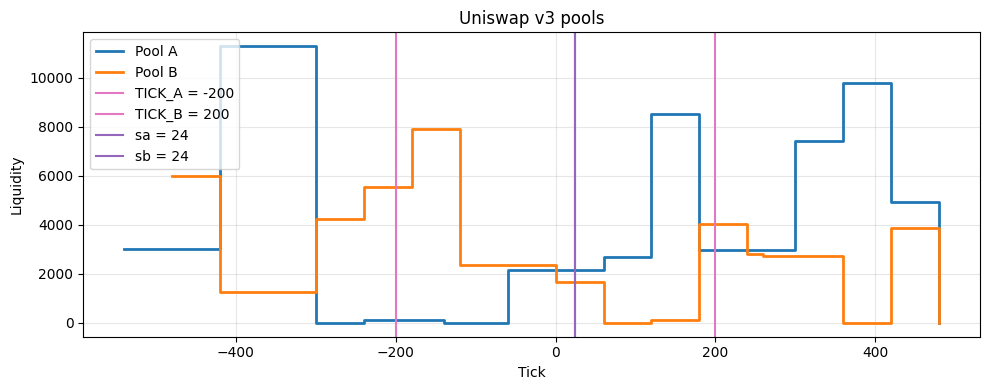

In [16]:
import math
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

# Fee Tier | Typical Tick Spacing
# -------- | --------------------
# 0.05%    | 1
# 0.3%     | 60
# 1%       | 200
# 10%      | 2000

TICK_SPACING_A = 60
TICK_SPACING_B = 60
FEE_A = 0.003
FEE_B = 0.0005

TICK_A = -200
TICK_B = 200


def random_positions(
    n_positions,
    tick_min=-500,
    tick_max=500,
    tick_spacing=10,
    min_width=20,
    max_width=200,
    min_liquidity=0,
    max_liquidity=6000,
):
    positions = []

    # snap tick_min and tick_max to tick spacing
    tick_min = (tick_min // tick_spacing) * tick_spacing
    tick_max = (tick_max // tick_spacing) * tick_spacing

    for _ in range(n_positions):
        # generate lower tick as multiple of tick_spacing
        lower = (
            random.randint(
                tick_min // tick_spacing, (tick_max - min_width) // tick_spacing
            )
            * tick_spacing
        )

        # random width in ticks, then snap upper
        width = random.randint(min_width, max_width)
        upper = lower + width
        # snap upper to tick spacing
        upper = ((upper + tick_spacing - 1) // tick_spacing) * tick_spacing
        if upper > tick_max:
            upper = tick_max

        liquidity = random.randint(min_liquidity, max_liquidity)
        positions.append((lower, upper, liquidity))

    return positions


def build_liq(positions):
    liq_net = defaultdict(float)

    for lower, upper, L in positions:
        liq_net[lower] += L
        liq_net[upper] -= L

    ticks = np.array(sorted(liq_net.keys()))
    delta = np.array([liq_net[t] for t in ticks])
    liqs = np.cumsum(delta)

    # [(lower tick, upper tick, liquidity)]
    pool = []
    for i in range(len(ticks) - 1):
        if liqs[i] == 0:
            continue
        pool.append((ticks[i], ticks[i + 1], liqs[i]))

    return ticks, liqs, pool


def prep(pool, tick, up):
    # Check
    t = -math.inf
    for lo, hi, L in pool:
        assert t <= lo < hi
        t = lo
    # Slice
    s = []
    if up:
        assert any(lo <= tick <= hi for lo, hi, L in pool)
        s = [(lo, hi, L) for lo, hi, L in pool if tick < hi]
        assert len(s) > 0
        # print(up, s)
        (lo, hi, L) = s[0]
        assert lo <= tick
        s[0] = (tick, hi, L)
    else:
        assert any(lo <= tick <= hi for lo, hi, L in pool)
        s = [(lo, hi, L) for lo, hi, L in pool if lo < tick]
        assert len(s) > 0
        # print(up, s)
        (lo, hi, L) = s[-1]
        assert hi >= tick
        s[-1] = (lo, tick, L)
        s.reverse()
    # Map
    return [
        (tick_to_sqrt_p(tick_lo), tick_to_sqrt_p(tick_hi), L)
        for tick_lo, tick_hi, L in s
    ]


pool_a_positions = random_positions(n_positions=10, tick_spacing=TICK_SPACING_A)
pool_a_positions.append(
    (
        round_tick(TICK_A - TICK_SPACING_A, TICK_SPACING_A),
        round(TICK_A + TICK_SPACING_A, TICK_SPACING_A),
        100,
    )
)
pool_b_positions = random_positions(n_positions=10, tick_spacing=TICK_SPACING_B)
pool_b_positions.append(
    (
        round_tick(TICK_B - TICK_SPACING_B, TICK_SPACING_B),
        round(TICK_B + TICK_SPACING_B, TICK_SPACING_B),
        100,
    )
)

ticks_a, liq_a, pool_a = build_liq(pool_a_positions)
ticks_b, liq_b, pool_b = build_liq(pool_b_positions)

pool_a = prep(pool_a, TICK_A, True)
pool_b = prep(pool_b, TICK_B, False)

(dya, dyb, sa, sb) = calc_dya(pool_a, pool_b, FEE_A, FEE_B)
print("sim", "dya:", dya, "dyb:", dyb, "sa:", sa, "sb:", sb)
print("dyb - dya:", dyb - dya)

# TODO: clean - use function
plt.figure(figsize=(10, 4))

plt.step(ticks_a, liq_a, where="post", linewidth=2, label="Pool A")
plt.step(ticks_b, liq_b, where="post", linewidth=2, label="Pool B")

plt.axvline(TICK_A, linewidth=1.5, color="tab:pink", label=f"TICK_A = {TICK_A}")
plt.axvline(TICK_B, linewidth=1.5, color="tab:pink", label=f"TICK_B = {TICK_B}")
plt.axvline(
    sqrt_p_to_tick(sa),
    linewidth=1.5,
    color="tab:purple",
    label=f"sa = {sqrt_p_to_tick(sa)}",
)
plt.axvline(
    sqrt_p_to_tick(sb),
    linewidth=1.5,
    color="tab:purple",
    label=f"sb = {sqrt_p_to_tick(sb)}",
)

plt.xlabel("Tick")
plt.ylabel("Liquidity")
plt.title("Uniswap v3 pools")

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
import json


class Liquidity:
    def __init__(self, **kwargs):
        self.lo = kwargs["lo"]
        self.hi = kwargs["hi"]
        self.net = kwargs["net"]
        self.liq = kwargs["liq"]

    def __str__(self):
        return f"Liquidity(lo={self.lo}, hi={self.hi}, net={self.net}, liq={self.liq})"


def get(file_path):
    with open(file_path) as f:
        data = json.load(f)

    pool = []
    for entry in data:
        pool.append(Liquidity(**entry))

    return pool


def build(data, asc):
    assert len(data) > 0

    if not asc:
        data.reverse()

    # Check tick is increasing
    t = -math.inf
    for l in data:
        assert t <= l.lo < l.hi
        assert l.liq >= 0
        t = l.lo

    tick = data[0].lo if asc else data[-1].hi

    ticks = []
    liqs = []
    for l in data:
        ticks.append(l.lo)
        liqs.append(l.liq)

        ticks.append(l.hi)
        liqs.append(l.liq)

    pool = [(tick_to_sqrt_p(l.lo), tick_to_sqrt_p(l.hi), l.liq) for l in data]
    if not asc:
        pool.reverse()

    return ticks, liqs, pool, tick

199922 199930
sim dya: 0 dyb: 0 sa: 21929.76725605733 sb: 21938.540478833507
dyb - dya: 0


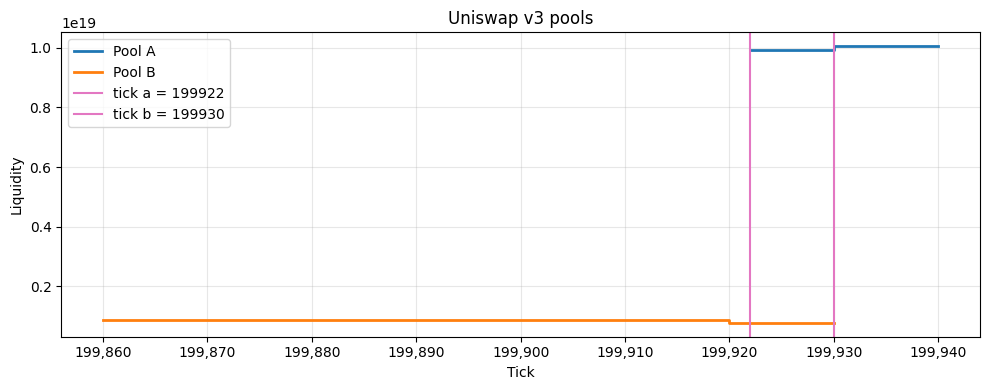

In [33]:
import math
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np


def plot(ticks_a, ticks_b, liqs_a, liqs_b, tick_a, tick_b):
    plt.figure(figsize=(10, 4))

    # TODO: generalize?
    # Show price on X axis
    # plt.gca().xaxis.set_major_formatter(
    #     mticker.FuncFormatter(lambda t, _: f"{int(1e12/tick_to_p(t)):,}")
    # )
    plt.gca().xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda t, _: f"{int(t):,}")
    )

    plt.step(ticks_a, liqs_a, where="post", linewidth=2, label="Pool A")
    plt.step(ticks_b, liqs_b, where="post", linewidth=2, label="Pool B")

    plt.axvline(tick_a, linewidth=1.5, color="tab:pink", label=f"tick a = {tick_a}")
    plt.axvline(tick_b, linewidth=1.5, color="tab:pink", label=f"tick b = {tick_b}")

    plt.xlabel("Tick")
    plt.ylabel("Liquidity")
    plt.title("Uniswap v3 pools")

    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Fee Tier | Typical Tick Spacing
# -------- | --------------------
# 0.05%    | 1
# 0.3%     | 60
# 1%       | 200
# 10%      | 2000
fee_a = 0.0005
fee_b = 0.003

ticks_a, liqs_a, pool_a, tick_a = build(get("tmp/pool_a.json"), True)
ticks_b, liqs_b, pool_b, tick_b = build(get("tmp/pool_b.json"), False)

print(tick_a, tick_b)

(dya, dyb, sa, sb) = calc_dya(pool_a, pool_b, fee_a, fee_b)
print("sim", "dya:", dya, "dyb:", dyb, "sa:", sa, "sb:", sb)
print("dyb - dya:", dyb - dya)

plot(ticks_a, ticks_b, liqs_a, liqs_b, tick_a, tick_b)